In [1]:
import nfl_data_py as nfl
import pandas as pd
import os
import urllib.request
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

In [58]:
# pbp = nfl.import_pbp_data([2022])
pbp = pd.read_csv('scrape/nfl_data_py/df_pbp_2016_2022.csv')

C:\Users\grant\AppData\Local\Temp\ipykernel_25652\892554206.py:2: DtypeWarning: Columns (179,180,182,183,189,190,193,194,197,198,203,204,205,206,209,210,213,214,218,219,220,222,224,226,233,234,235,236,237,238,243,244,245,248,249,253,254,255,260,262,263,266,267,268,269,283,284,301) have mixed types. Specify dtype option on import or set low_memory=False.
  pbp = pd.read_csv('scrape/nfl_data_py/df_pbp_2016_2022.csv')


In [63]:
df = pbp[(pbp['season'] == 2022) & (pbp['season_type'] == 'REG') & (pbp['desc'] == 'END GAME')]
cols = ['week', 'home_team', 'away_team', 'home_score', 'away_score']
df = df[cols]
df['home_win'] = df['home_score'] > df['away_score']

home = df[['week', 'home_team', 'home_win']].rename(columns={'home_team': 'team', 'home_win': 'win'})
away = df[['week', 'away_team', 'home_win']].rename(columns={'away_team': 'team', 'home_win': 'win'})
away['win'] = ~away['win']

wins = pd.concat([home, away]).reset_index(drop=True)
wins.head()

,week,team,win
0,1,NYJ,False
1,1,LA,False
2,1,CAR,False
3,1,SEA,True
4,1,MIN,True


In [64]:
win_counts = wins.drop(columns=['week']).groupby('team').sum().reset_index()
win_counts.rename(columns={'win': 'win_count'}, inplace=True)
win_counts.sort_values('win_count', ascending=False, inplace=True)
win_counts.head()

,team,win_count
25,PHI,14
15,KC,14
3,BUF,13
20,MIN,13
28,SF,13


In [67]:
pbp_rp = pbp[(pbp['pass'] == 1) | (pbp['rush'] == 1)]
pbp_rp = pbp_rp.dropna(subset=['epa', 'posteam', 'defteam'])

off_epa = pbp_rp.groupby('posteam')['epa'].mean().reset_index().rename(columns = {'epa' : 'all'})
off_pass_epa = pbp_rp[(pbp_rp['pass'] == 1)].groupby('posteam')['epa'].mean().reset_index().rename(columns = {'epa' : 'pass'})
off_epa = pd.merge(off_epa, off_pass_epa, on = 'posteam')
off_rush_epa = pbp_rp[(pbp_rp['rush'] == 1)].groupby('posteam')['epa'].mean().reset_index().rename(columns = {'epa' : 'rush'})
off_epa = pd.merge(off_epa, off_rush_epa, on = 'posteam').rename(columns = {'posteam' : 'team'})

def_epa = pbp_rp.groupby('defteam')['epa'].mean().reset_index().rename(columns = {'epa' : 'all'})
def_pass_epa = pbp_rp[(pbp_rp['pass'] == 1)].groupby('defteam')['epa'].mean().reset_index().rename(columns = {'epa' : 'pass'})
def_epa = pd.merge(def_epa, def_pass_epa, on = 'defteam')
def_rush_epa = pbp_rp[(pbp_rp['rush'] == 1)].groupby('defteam')['epa'].mean().reset_index().rename(columns = {'epa' : 'rush'})
def_epa = pd.merge(def_epa, def_rush_epa, on = 'defteam').rename(columns = {'defteam' : 'team'})

epa = pd.merge(off_epa, def_epa, on = 'team', suffixes=('_off', '_def'))
epa['net'] = epa['all_off'] - epa['all_def']
epa.sort_values('net').head()

,team,all_off,pass_off,rush_off,all_def,pass_def,rush_def,net
24,NYJ,-0.098764,-0.074333,-0.139590,0.037804,0.139372,-0.119124,-0.136568
10,DET,-0.005020,0.079227,-0.153639,0.081781,0.165139,-0.046311,-0.086802
23,NYG,-0.053915,-0.035789,-0.086325,0.029885,0.091395,-0.066637,-0.083800
18,LV,0.004746,0.075059,-0.110652,0.087934,0.185352,-0.061197,-0.083188
12,HOU,-0.041247,0.025514,-0.156585,0.034470,0.107446,-0.074726,-0.075718


In [69]:
df = pd.merge(win_counts, epa, on = 'team')
df.to_csv('delete.csv')
df.head()

,team,win_count,all_off,pass_off,rush_off,all_def,pass_def,rush_def,net
0,PHI,14,0.035490,0.085967,-0.043618,-0.020021,0.025002,-0.101815,0.055511
1,KC,14,0.145748,0.238329,-0.039415,0.031620,0.065504,-0.028808,0.114128
2,BUF,13,0.031524,0.090583,-0.066746,-0.024971,-0.000596,-0.064194,0.056495
3,MIN,13,0.009363,0.096722,-0.127761,-0.031914,0.006839,-0.095041,0.041277
4,SF,13,0.015766,0.087792,-0.081775,-0.007425,0.056136,-0.107784,0.023191


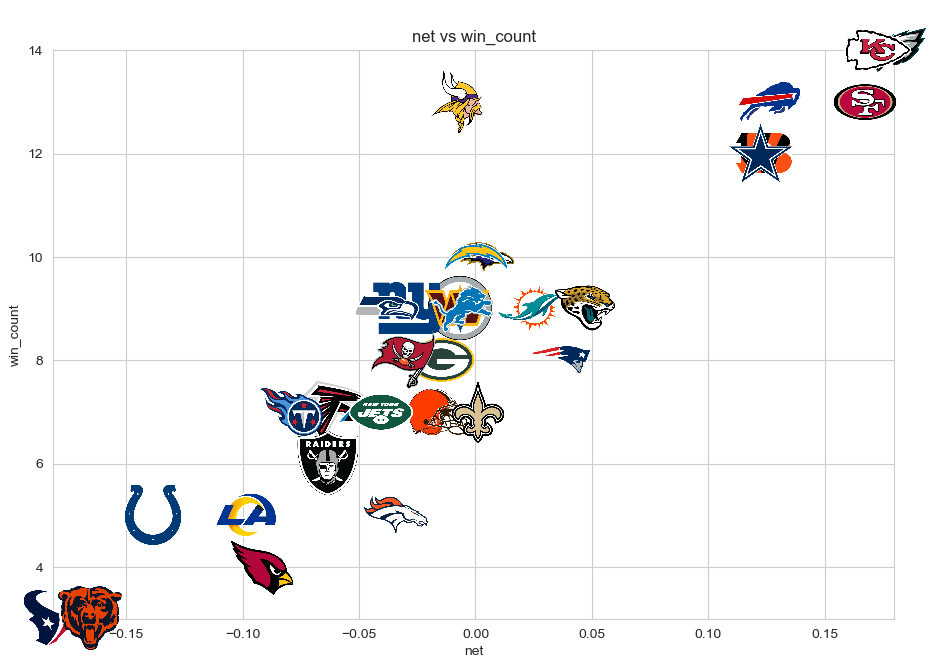

In [22]:
def chart_epa_vs_wins(df, x_name='net', y_name='win_count'):
    
    logos = nfl.import_team_desc()[['team_abbr', 'team_logo_espn']]
    
    logo_paths = []
    team_abbr = []
    if not os.path.exists("logos"):
        os.makedirs("logos")

    for team in range(len(logos)):
        urllib.request.urlretrieve(logos['team_logo_espn'][team], f"logos/{logos['team_abbr'][team]}.tif")
        logo_paths.append(f"logos/{logos['team_abbr'][team]}.tif")
        team_abbr.append(logos['team_abbr'][team])

    data = {'team_abbr' : team_abbr, 'logo_path' : logo_paths}
    logo_data = pd.DataFrame(data)

    epa_with_logos = pd.merge(df, logo_data, left_on = 'team', right_on = 'team_abbr')

    
    plt.rcParams["figure.figsize"] = [10, 7]
    plt.rcParams["figure.autolayout"] = True

    def getImage(path):
        return OffsetImage(plt.imread(path, format="tif"), zoom=.1)

    x = epa_with_logos[x_name]
    y = epa_with_logos[y_name]
    paths = epa_with_logos['logo_path']

    fig, ax = plt.subplots()

    for x0, y0, path in zip(x, y, paths):
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)

    xmin = min(x)
    xmax = max(x)
    ymin = min(y)
    ymax = max(y)

    # buffer = 0.05
    buffer = 0
    plt.xlim(xmin-buffer, xmax+buffer)
    plt.ylim(ymin-buffer, ymax+buffer)

    plt.title(f"{x_name} vs {y_name}")
    plt.xlabel(f"{x_name}")
    plt.ylabel(f"{y_name}")
    plt.show()
    
chart_epa_vs_wins(df.copy())

In [23]:
correlation = df.corr()['win_count'].drop('win_count')
correlation

C:\Users\grant\AppData\Local\Temp\ipykernel_23812\744148963.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df.corr()['win_count'].drop('win_count')


all_off     0.827880
pass_off    0.840637
rush_off    0.384532
all_def    -0.402120
pass_def   -0.438205
rush_def   -0.181815
net         0.906211
Name: win_count, dtype: float64

In [24]:
import statsmodels.api as sm

X = df[['all_off', 'pass_off', 'rush_off', 'all_def', 'pass_def', 'rush_def', 'net']]
X = sm.add_constant(X)

y = df['win_count']

model = sm.OLS(y, X).fit()

model_summary = model.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              win_count   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     22.24
Date:                Thu, 14 Sep 2023   Prob (F-statistic):           4.89e-09
Time:                        16:11:16   Log-Likelihood:                -48.462
No. Observations:                  32   AIC:                             112.9
Df Residuals:                      24   BIC:                             124.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.2743      0.456     18.131      0.000       7.332       9.216
all_off     1.219e+08   9.46e+07      1.289      0.210   -7.33e+07    3.17e+08
pass_off     -22.8846     22.672     -1.009      0.323     -69.676      23.907
rush_off     -18.1270     12.922     -1.403      0.173     -44.797       8.543
all_def    -1.219e+08   9.46e+07     -1.289      0.210   -3.17e+08    7.33e+07
pass_def     -29.4841     29.970     -0.984      0.335     -91.340      32.372
rush_def     -18.1191     17.123     -1.058      0.301     -53.459      17.221
net        -1.219e+08   9.46e+07     -1.289      0.210   -3.17e+08    7.33e+07
==============================================================================
Omnibus:                       10.106   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.290
Skew:                           0.887   Prob(JB):                      0.00583
Kurtosis:                       5.137   Cond. No.                     7.33e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.02e-17. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

- P-values
    - P-values help us determine the statistical significance of the coefficients. A smaller p-value (typically < 0.05) indicates that you can reject the null hypothesis and that the coefficient is statistically significant.
    - None of the coefficients have p-values less than 0.05, which indicates that at a 95% confidence level, none of the predictors in this model are statistically significant.
- Multicollinearity Warning:
The note at the bottom indicates potential multicollinearity problems. Multicollinearity occurs when independent variables in a regression model are correlated. This can lead to unreliable and unstable estimates of regression coefficients. The variables all_off, all_def, and net seem to be highly correlated, which could be leading to this issue.

In [25]:
X_refined = df[['pass_off', 'rush_off', 'pass_def', 'rush_def']]
X_refined = sm.add_constant(X_refined)

model_refined = sm.OLS(y, X_refined).fit()

model_refined_summary = model_refined.summary()
model_refined_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              win_count   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     34.50
Date:                Thu, 14 Sep 2023   Prob (F-statistic):           3.00e-10
Time:                        16:11:16   Log-Likelihood:                -51.709
No. Observations:                  32   AIC:                             113.4
Df Residuals:                      27   BIC:                             120.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.2335      0.446     18.459      0.000       7.318       9.149
pass_off      22.4861      2.595      8.667      0.000      17.163      27.810
rush_off       7.5825      4.110      1.845      0.076      -0.850      16.015
pass_def     -12.4390      3.649     -3.409      0.002     -19.927      -4.951
rush_def      -8.5982      3.967     -2.167      0.039     -16.738      -0.458
==============================================================================
Omnibus:                       12.026   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.215
Skew:                           1.026   Prob(JB):                      0.00135
Kurtosis:                       5.387   Cond. No.                         19.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- P-values
    - The p-values for pass_off, pass_def, and rush_def are all less than 0.05, indicating that these predictors are statistically significant at a 95% confidence level.
    - rush_off has a p-value slightly above 0.05, making it marginally significant.
- No Multicollinearity Warning: With the refined model, we don't see any warnings related to multicollinearity, which is a good sign.
- Interpretation
    - An increase in pass_off tends to significantly increase the win_count.
    - Conversely, increases in pass_def and rush_def tend to significantly decrease the win_count.
    - rush_off has a positive effect on the win_count, but the relationship is marginally significant.

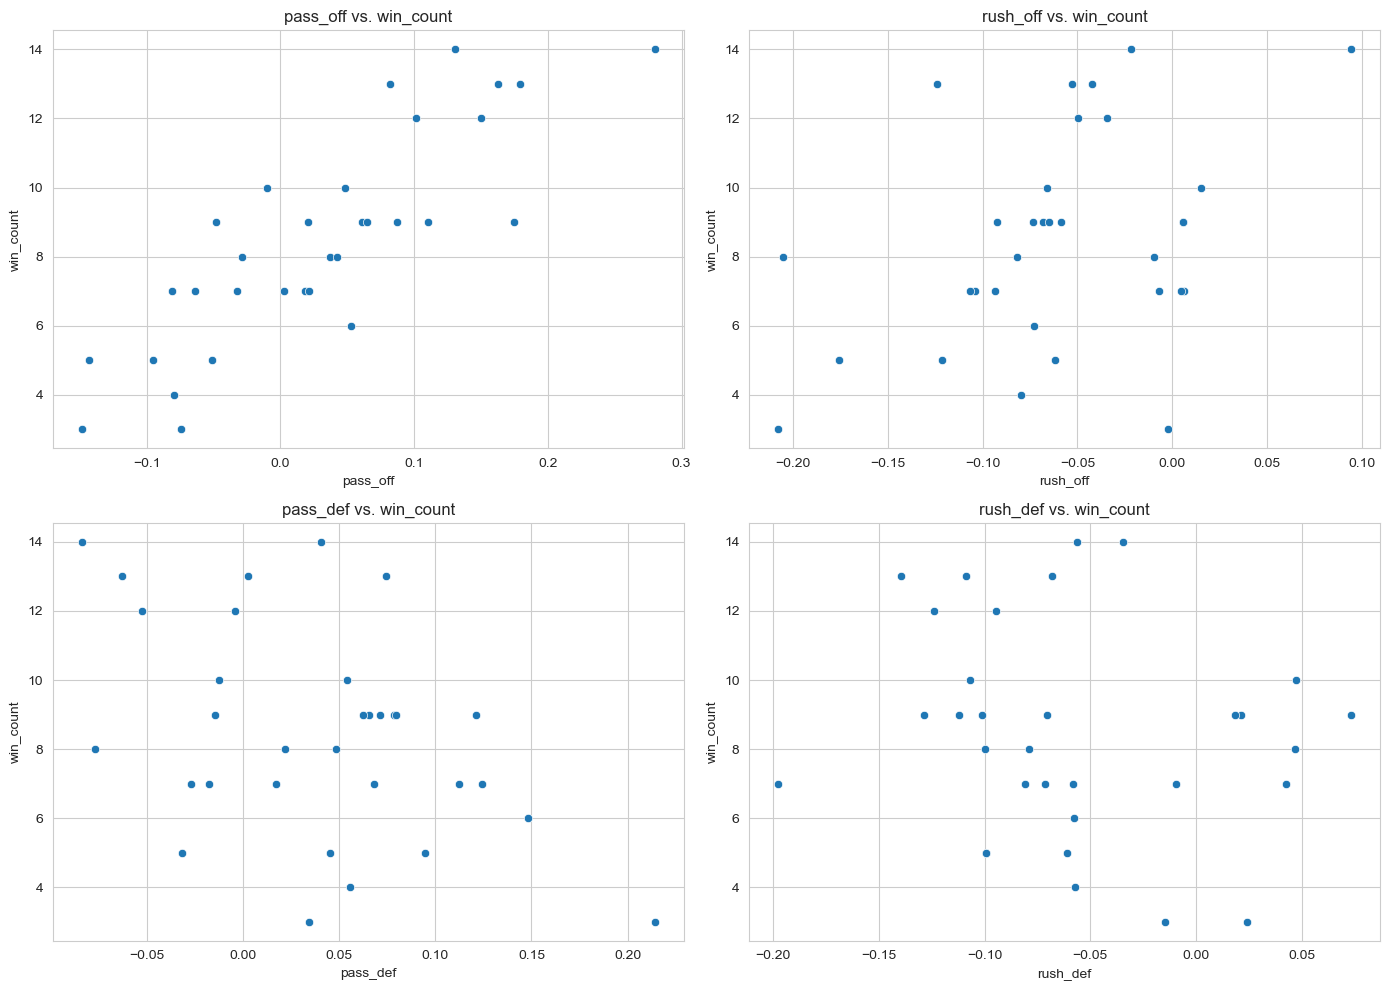

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.scatterplot(data=df, x='pass_off', y='win_count', ax=axes[0, 0])
axes[0, 0].set_title('pass_off vs. win_count')

sns.scatterplot(data=df, x='rush_off', y='win_count', ax=axes[0, 1])
axes[0, 1].set_title('rush_off vs. win_count')

sns.scatterplot(data=df, x='pass_def', y='win_count', ax=axes[1, 0])
axes[1, 0].set_title('pass_def vs. win_count')

sns.scatterplot(data=df, x='rush_def', y='win_count', ax=axes[1, 1])
axes[1, 1].set_title('rush_def vs. win_count')

plt.tight_layout()
plt.show()

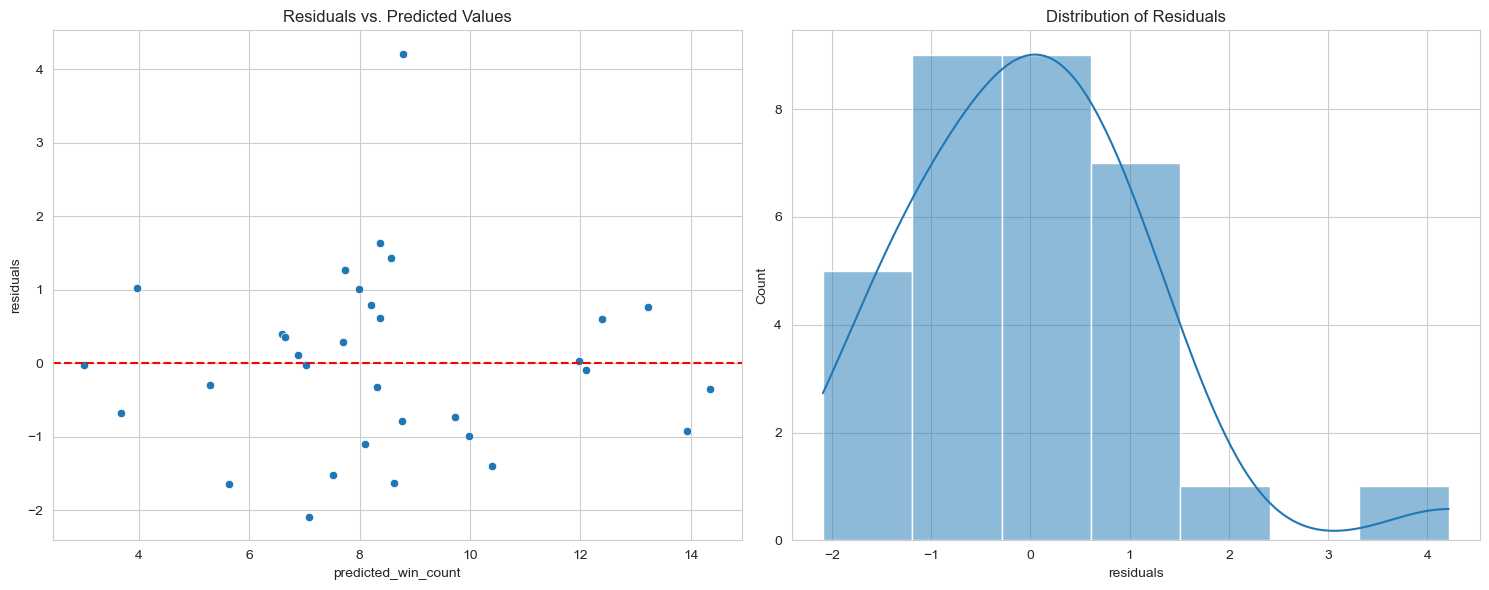

In [27]:
df['predicted_win_count'] = model_refined.predict(X_refined)
df['residuals'] = df['win_count'] - df['predicted_win_count']

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.scatterplot(data=df, x='predicted_win_count', y='residuals', ax=axes[0])
axes[0].set_title('Residuals vs. Predicted Values')
axes[0].axhline(y=0, color='r', linestyle='--')

sns.histplot(data=df, x='residuals', kde=True, ax=axes[1])
axes[1].set_title('Distribution of Residuals')

plt.tight_layout()
plt.show()


- Residuals vs. Predicted Values
    - The residuals are scattered around the zero line, which is a good indication of linearity.
    - The spread of residuals appears to be fairly consistent across predicted values, suggesting homoscedasticity. There are no clear patterns or funnels in the plot, which would have indicated problems.
- Distribution of Residuals: The residuals seem to be approximately normally distributed, as indicated by the bell-shaped curve.

From this residual analysis, it seems that the assumptions of linear regression are reasonably well met with our refined model.

In [28]:
df['pass_rush_interaction'] = df['pass_off'] * df['rush_off']

X_interaction = X_refined.copy()
X_interaction['pass_rush_interaction'] = df['pass_rush_interaction']

model_interaction = sm.OLS(y, X_interaction).fit()

model_interaction_summary = model_interaction.summary()
model_interaction_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              win_count   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     26.58
Date:                Thu, 14 Sep 2023   Prob (F-statistic):           1.90e-09
Time:                        16:11:18   Log-Likelihood:                -51.708
No. Observations:                  32   AIC:                             115.4
Df Residuals:                      26   BIC:                             124.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     8.2272      0.495     16.630      0.000       7.210       9.244
pass_off                 22.5783      3.909      5.777      0.000      14.544      30.613
rush_off                  7.5845      4.188      1.811      0.082      -1.025      16.194
pass_def                -12.3891      4.032     -3.073      0.005     -20.677      -4.101
rush_def                 -8.6157      4.079     -2.112      0.044     -17.000      -0.231
pass_rush_interaction     1.3197     41.207      0.032      0.975     -83.383      86.022
==============================================================================
Omnibus:                       12.189   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.505
Skew:                           1.036   Prob(JB):                      0.00117
Kurtosis:                       5.416   Cond. No.                         174.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- The coefficient for pass_rush_interaction is 1.3197, but with a very high standard error.
- The p-value for the interaction term is 0.975, which is much greater than 0.05. This indicates that the interaction term is not statistically significant in predicting win_count given our current model.

In simpler terms, the interaction between passing offense (pass_off) and rushing offense (rush_off) doesn't provide additional information about win_count beyond what's already captured by the individual terms.

Note this may not accurately capture when a team fumbles once and then the other team fumbles but have spent hours with the data and haven't found a good solve for this. Should be extremtly rare, can circle back.

In [83]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

data = df.copy()

# Extracting the relevant columns for the regression model
X = data[['pass_off', 'rush_off', 'pass_def', 'rush_def']]
y = data['win_count']

# Initialize the regression model
model = LinearRegression()

# Fit the model
model.fit(X, y)

# # Predict the win_count using the model
data['predicted_win_count'] = model.predict(X)
data['predicted_win_count'] = round(data['predicted_win_count'], 1)

# Calculate the residuals (difference between predicted and actual win count)
data['residuals'] = data['win_count'] - data['predicted_win_count']
data['residuals_abs'] = abs(data['residuals'])

# # Find the team with the largest absolute residual
# team_with_largest_residual = data.loc[data['residuals'].abs().idxmax()]

# team_with_largest_residual[['team', 'win_count', 'predicted_win_count', 'residuals']]

# table = data[['team', 'win_count', 'predicted_win_count', 'residuals']].sort_values('residuals', ascending=False)
table = data[['team', 'win_count', 'predicted_win_count', 'residuals', 'residuals_abs']].sort_values('residuals_abs', ascending=False)


In [81]:
# highest overachievers
data[['team', 'win_count', 'predicted_win_count', 'residuals', 'residuals_abs']].sort_values('residuals', ascending=False).head()

,team,win_count,predicted_win_count,residuals,residuals_abs
0,PHI,14,9.2,4.8,4.8
4,SF,13,8.4,4.6,4.6
3,MIN,13,9.6,3.4,3.4
24,NYJ,7,3.8,3.2,3.2
5,CIN,12,9.0,3.0,3.0


In [82]:
# highest underachievers
data[['team', 'win_count', 'predicted_win_count', 'residuals', 'residuals_abs']].sort_values('residuals', ascending=True).head()

,team,win_count,predicted_win_count,residuals,residuals_abs
30,HOU,3,7.1,-4.1,4.1
26,LA,5,9.1,-4.1,4.1
31,CHI,3,6.9,-3.9,3.9
18,NE,8,11.2,-3.2,3.2
29,ARI,4,6.9,-2.9,2.9


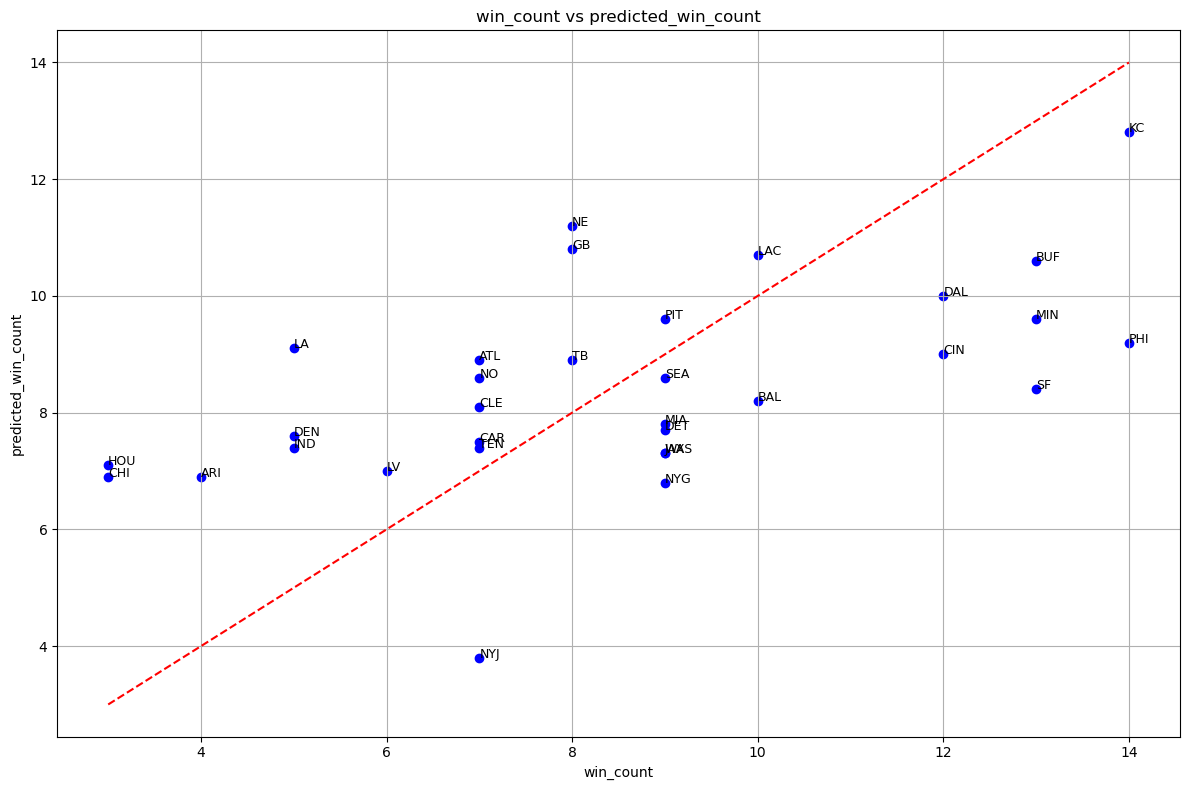

In [85]:
import matplotlib.pyplot as plt

x = 'win_count'
y = 'predicted_win_count'


plt.figure(figsize=(12, 8))

plt.scatter(data[x], data[y], color='blue')

for idx, row in data.iterrows():
    plt.annotate(row['team'], (row[x], row[y]), fontsize=9)

plt.plot([data[x].min(), data[x].max()], 
         [data[x].min(), data[x].max()], 
         color='red', linestyle='--')

plt.title(f'{x} vs {y}')
plt.xlabel(f'{x}')
plt.ylabel(f'{y}')
plt.grid(True)
plt.tight_layout()

plt.show()

In [2]:
pbp = pd.read_csv('scrape/nfl_data_py/df_pbp_2016_2022.csv')
pbp = pbp[(pbp['season_type'] == 'REG')]

C:\Users\grant\AppData\Local\Temp\ipykernel_25652\276358757.py:1: DtypeWarning: Columns (179,180,182,183,189,190,193,194,197,198,203,204,205,206,209,210,213,214,218,219,220,222,224,226,233,234,235,236,237,238,243,244,245,248,249,253,254,255,260,262,263,266,267,268,269,283,284,301) have mixed types. Specify dtype option on import or set low_memory=False.
  pbp = pd.read_csv('scrape/nfl_data_py/df_pbp_2016_2022.csv')


In [44]:
fumbles = pbp[pbp['fumble_lost'] == 1]
fumbles = fumbles[['season', 'week', 'fumbled_1_team']]
fumbles.rename(columns={'fumbled_1_team': 'team'}, inplace=True)
fumbles = fumbles.groupby(['season', 'week','team']).size().reset_index(name='fumbles').sort_values(['season','team', 'week'])

interceptions = pbp[pbp['interception'] == 1]
interceptions = interceptions[['season', 'week', 'posteam']]
interceptions.rename(columns={'posteam': 'team'}, inplace=True)
interceptions = interceptions.groupby(['season', 'week','team']).size().reset_index(name='interceptions').sort_values(['season', 'team', 'week'])

turnovers = pd.merge(fumbles, interceptions, on=['team', 'week', 'season'], how='outer')
turnovers.fillna(0, inplace=True)
turnovers['turnovers'] = turnovers['fumbles'] + turnovers['interceptions']

schedule = pbp[pbp['desc'] == 'END GAME']
schedule = schedule[['season', 'week', 'home_team', 'away_team', 'home_score', 'away_score']].drop_duplicates().reset_index(drop=True)

df = pd.merge(schedule, turnovers[['season', 'week','team', 'turnovers']].rename(columns={'team': 'home_team', 'turnovers': 'home_turnovers'}), on=['season', 'week', 'home_team'], how='left')
df = pd.merge(df, turnovers[['season', 'week','team', 'turnovers']].rename(columns={'team': 'away_team', 'turnovers': 'away_turnovers'}), on=['season', 'week', 'away_team'], how='left')
df.fillna(0, inplace=True)
df['home_vs_away_turnovers'] = df['home_turnovers'] - df['away_turnovers']
df['home_vs_away_score'] = df['home_score'] - df['away_score']
df['home_outcome'] = 'Loss'
df.loc[df['home_vs_away_score'] > 0, 'home_outcome'] = 'Win'
df.loc[df['home_vs_away_score'] == 0, 'home_outcome'] = 'Tie'
df['home_win_binary'] = 0
df.loc[df['home_vs_away_score'] > 0, 'home_win_binary'] = 1
df.head()

,season,week,home_team,away_team,home_score,away_score,home_turnovers,away_turnovers,home_vs_away_turnovers,home_vs_away_score,home_outcome,home_win_binary
0,2016,1,BAL,BUF,13,7,1.0,0.0,1.0,6,Win,1
1,2016,1,DEN,CAR,21,20,3.0,1.0,2.0,1,Win,1
2,2016,1,HOU,CHI,23,14,1.0,1.0,0.0,9,Win,1
3,2016,1,NYJ,CIN,22,23,1.0,1.0,0.0,-1,Loss,0
4,2016,1,PHI,CLE,29,10,0.0,1.0,-1.0,19,Win,1


In [46]:
round(df['home_outcome'].value_counts() / len(df), 3)

Win     0.544
Loss    0.451
Tie     0.005
Name: home_outcome, dtype: float64

In [48]:
round(df[df['season'] != 2020]['home_outcome'].value_counts() / len(df[df['season'] != 2020]), 3)

Win     0.552
Loss    0.443
Tie     0.005
Name: home_outcome, dtype: float64

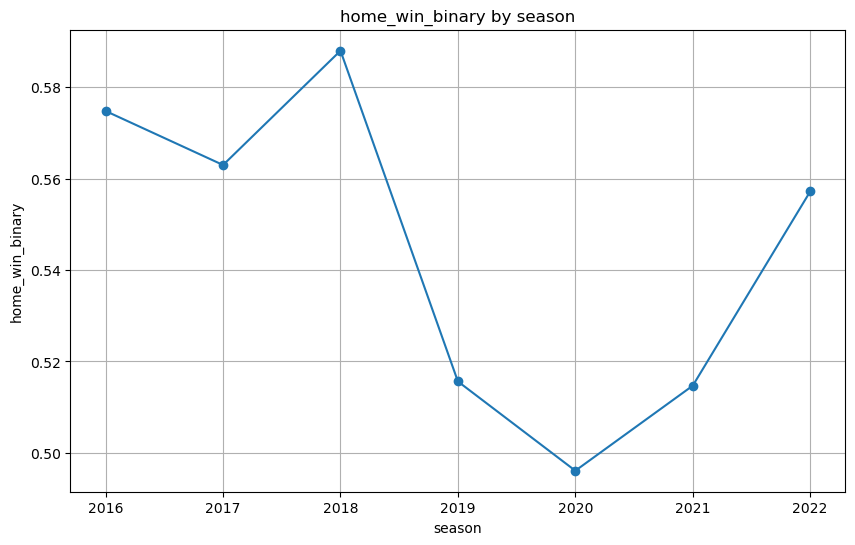

In [49]:
y = 'home_win_binary'
x = 'season'

test = df.groupby(x)[y].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(test[x], test[y], marker='o')
plt.title(f'{y} by {x}')
plt.xlabel(f'{x}')
plt.ylabel(f'{y}')
plt.grid(True)
plt.show()

In [51]:
df['home_vs_away_score'].mean()

1.4964147821290679

In [50]:
df[df['season'] != 2020]['home_vs_away_score'].mean()

1.7334617854849068

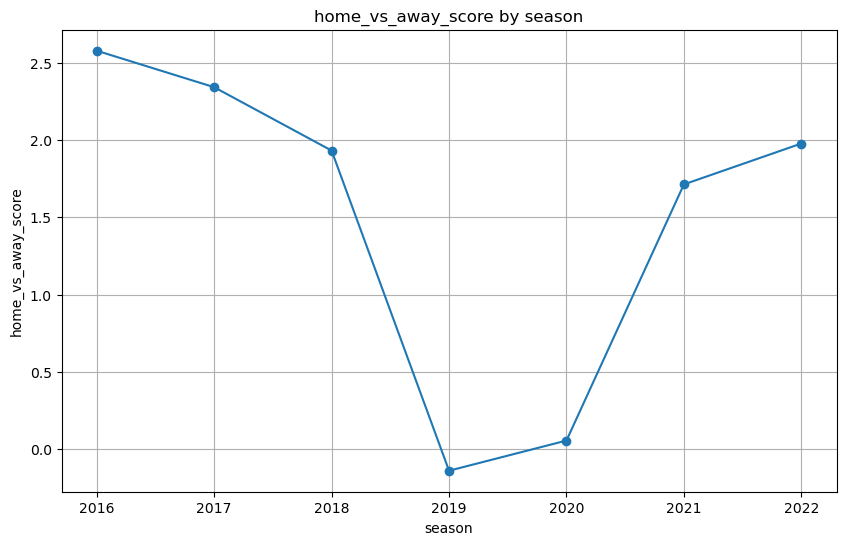

In [40]:
y = 'home_vs_away_score'
x = 'season'

test = df.groupby(x)[y].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(test[x], test[y], marker='o')
plt.title(f'{y} by {x}')
plt.xlabel(f'{x}')
plt.ylabel(f'{y}')
plt.grid(True)
plt.show()

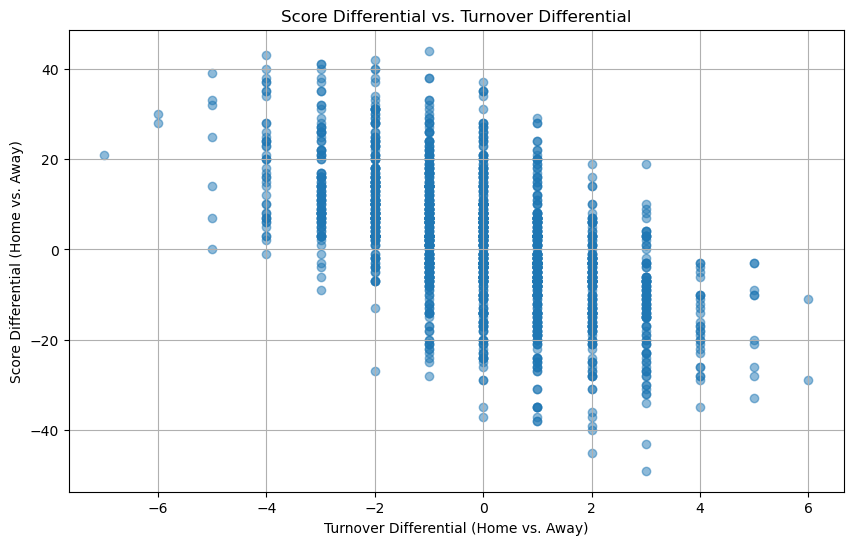

In [22]:
data = df.copy()

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(data['home_vs_away_turnovers'], data['home_vs_away_score'], alpha=0.5)
plt.title('Score Differential vs. Turnover Differential')
plt.xlabel('Turnover Differential (Home vs. Away)')
plt.ylabel('Score Differential (Home vs. Away)')
plt.grid(True)
plt.show()

In [5]:
correlation_coefficient = data['home_vs_away_turnovers'].corr(data['home_vs_away_score'])
correlation_coefficient

-0.5836223762967452

In [7]:
# Group by turnover differential and calculate the win rate
win_rate_by_turnover_diff = data.groupby('home_vs_away_turnovers')['home_outcome'].apply(lambda x: (x == 'Win').sum() / len(x)).reset_index()
win_rate_by_turnover_diff.columns = ['Turnover Differential', 'Win Rate']

# Calculate the number of games for each turnover differential
num_games_by_turnover_diff = data.groupby('home_vs_away_turnovers')['home_outcome'].count().reset_index()
num_games_by_turnover_diff.columns = ['Turnover Differential', 'Number of Games']

# Merge with the win rate table
win_rate_by_turnover_diff = win_rate_by_turnover_diff.merge(num_games_by_turnover_diff, on='Turnover Differential')

# Format the win rate to two decimal places
win_rate_by_turnover_diff['Win Rate'] = win_rate_by_turnover_diff['Win Rate'].round(2)

win_rate_by_turnover_diff

,Turnover Differential,Win Rate,Number of Games
0,-7.0,1.00,1
1,-6.0,1.00,2
2,-5.0,0.86,7
3,-4.0,0.98,42
4,-3.0,0.95,103
5,-2.0,0.90,220
6,-1.0,0.69,331
7,0.0,0.58,412
8,1.0,0.34,357
9,2.0,0.18,191


In [19]:
data[(data['home_vs_away_turnovers'] == -5.0) & (data['home_outcome'] == 'Tie')]

,season,week,home_team,away_team,home_score,away_score,home_turnovers,away_turnovers,home_vs_away_turnovers,home_vs_away_score,home_outcome
517,2018,1,CLE,PIT,21,21,1.0,6.0,-5.0,0,Tie


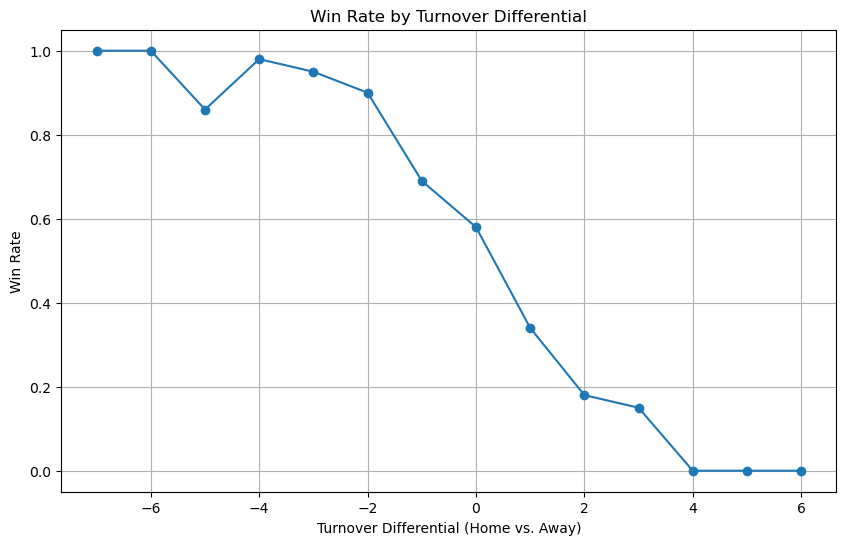

In [8]:
# Plotting the win rate against turnover differential
plt.figure(figsize=(10, 6))
plt.plot(win_rate_by_turnover_diff['Turnover Differential'], win_rate_by_turnover_diff['Win Rate'], marker='o')
plt.title('Win Rate by Turnover Differential')
plt.xlabel('Turnover Differential (Home vs. Away)')
plt.ylabel('Win Rate')
plt.grid(True)
plt.show()

In [9]:
# Calculate the average turnover differential for home games
avg_home_turnover_diff = data['home_vs_away_turnovers'].mean()

# Calculate the average turnover differential for away games (which is the negative of home turnover differential)
avg_away_turnover_diff = -avg_home_turnover_diff

avg_home_turnover_diff, avg_away_turnover_diff

(-0.03695532266960838, 0.03695532266960838)